# dl.ai NLP 1.1: sentiment analysis with frequency dictionaries and logistic regression
*deeplearning.ai NLP specialization (course)1.(week)1 notes by Samson Zhang*

## Why I'm taking this course and publishing this notebook

Andrew Ng's original [Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning) was my introduction to machine learning. I loved how rigorous it was -- I wrote a [blog post about how gradient descent works](https://www.samsonzhang.com/2020/09/27/how-excel-calculates-trendlines-and-how-you-can-too-an-introduction-to-gradient-descent-the-most-important-machine-learning-algorithm) and trained a [neural network written completely in numpy](https://www.samsonzhang.com/2020/11/24/understanding-the-math-behind-neural-networks-by-building-one-from-scratch-no-tf-keras-just-numpy) without ML libraries based on what I learned -- while also giving higher-level and practical insights into how ML models work and how they can be trained.

With my overall career interests moving towards writing and journalism, and influenced by a linguistics major friend of mine who I competed in UCLA DataFest with, I decided to dive into NLP this summer. I've had my eyes on [deeplearning.ai](https://deeplearning.ai/), a set of Coursera courses stewarded by Andrew Ng, for a while; and with deeplearning.ai's NLP specialization taught by one of the authors (Łukasz Kaiser) of the all-important [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper that shaped modern NLP, I had full faith in its courses and my learning strategy set.

But I don't think I'll retain that much from just breezing through the course. The only things I remember from the first ML course I took were the things I published blog posts about. So to give my learning more structure now in the absence of meaningful external tests or assignments, I'm going to publish Kaggle notebooks of what I learn in the courses, put in my own words and code. ([Learning in public](https://www.samsonzhang.com/2021/01/27/how-i-use-learning-in-public-as-my-personal-knowledge-management-strategy) has long been one of my favorite things to do.)

## Course intro

"NLP has changed a lot over the last several decades," Andrew Ng says in the course intro video. NLP started with rule-based programs, shifting to probabilistic models (that performed much better than rule-based ones but still required lots of hand-tuning) and finally deep learning ones (with attention models speeding up training significantly), he said.

The specialization will walk through basic logistic and naive Bayesian sentiment classifiers; probabilistic models; sequence models and finally attention models.

The course week of the first course starts off with basic encoding and pre-processing of text for supervised ML classification.

## Most basic approach: sparse representation

How does one represent words as numerical data for a machine learning algorithm?

The most straightforward way is by encoding each string as a vector, with each position of the vector corresponding to one word that appears in the relevant corpus and the value of that position being 1 if the string contains that word or 0 if it doesn't.

This representation is called a "sparse representation" because most of the vector positions will have a 0 value for any given string.

Though simple, the downside of this kind of encoding is that, as the vocabulary size grows, the number of parameters needed for a neural network will also grow (to vocabulary size + 1 [bias] for just the first layer), making it very slow to train.

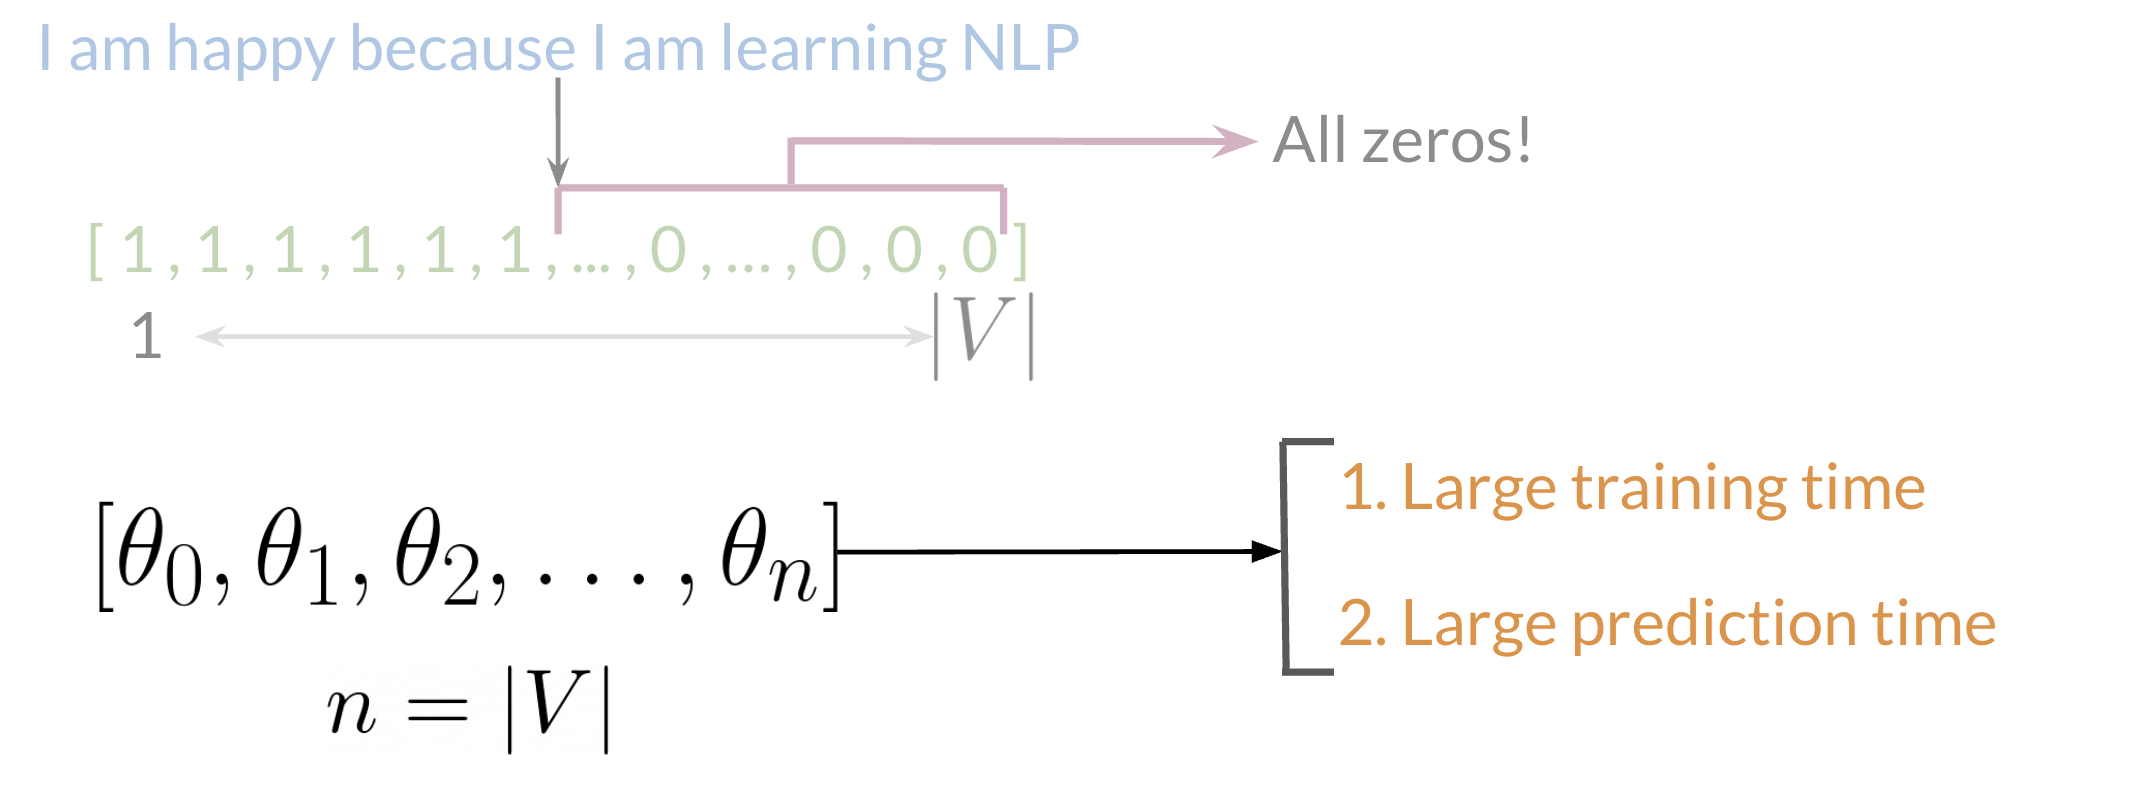

(Image -- like all others in these notebooks -- from the Coursera course)

So some more techniques can be used to clean text data and represent it in a much more concise way.

## Getting more concise: removing stop words, punctuation, etc.

The first step in representing text better is to pre-process it by removing stop words, punctuation and other unwanted information.

Let's try it out on some real data -- pre-labeled positive and negative tweets from NLTK's `twitter_samples` corpus. (The following code is adapted from Lab 1 of the course.)

In [1]:
import nltk
from nltk.corpus import twitter_samples

nltk.download('twitter_samples')
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

tweet = all_positive_tweets[2277]
print(tweet)

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i


First, we can strip out custom unwanted information like "RT", links and hashtags using regex. We can also make everything lowercase.

In [2]:
import re
tweet_clean = re.sub(r'^RT[\s]+', '', tweet)
tweet_clean = re.sub(r'https?://[^\s\n\r]+', '', tweet_clean)
tweet_clean = re.sub(r'#', '', tweet_clean)
tweet_clean = tweet_clean.lower()
print(tweet_clean)

my beautiful sunflowers on a sunny friday morning off :) sunflowers favourites happy friday off… 


Then, we can tokenize the string -- that is, turn it into an array of words and punctuation -- to more easily strip out stopwords and punctuation. NLTK provides a generic `word_tokenize` function for this, but we'll use its `TweetTokenizer`, which handles emoticons (`:)`) and other social media text better.

In [3]:
# generic tokenization:
# from nltk.tokenize import word_tokenize
# tweet_tokens = word_tokenize(tweet_clean)

from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
tweet_tokens = tokenizer.tokenize(tweet_clean)
print(tweet_tokens)

['my', 'beautiful', 'sunflowers', 'on', 'a', 'sunny', 'friday', 'morning', 'off', ':)', 'sunflowers', 'favourites', 'happy', 'friday', 'off', '…']


Lastly we can use NLTK's stop word and Python's built in punctuation lists to strip them out of our tokenized tweet.

In [4]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords_english = stopwords.words('english')
print(stopwords_english)

import string
print(string.punctuation)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any'

In [5]:
tweet_tokens = [token for token in tweet_tokens if (token not in stopwords_english and token not in string.punctuation)]
print(tweet_tokens)

['beautiful', 'sunflowers', 'sunny', 'friday', 'morning', ':)', 'sunflowers', 'favourites', 'happy', 'friday', '…']


## Getting more concise, pt. 2: stemming

To further improve our word representations we can convert them into stems. For example, "learn", "learning", "learned" and "learnt" have very similar semantic meanings, so we can convert them all to their root word "learn".

Other stemmings may convert words to non-words, like "happy", "happiness" and "happier" to "happi".

The Coursera lab uses NLTK's `PorterStemmer`, which uses the [Porter Stemming Algorithm](https://tartarus.org/martin/PorterStemmer/):

In [6]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
tweet_tokens = [stemmer.stem(token) for token in tweet_tokens]
print(tweet_tokens)

['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


Let's put everything together into one `process_tweet` function for future use.

In [7]:
# make sure everything is defined
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
stemmer = PorterStemmer()
stopwords_english = stopwords.words('english')    


def process_tweet(tweet):
    # clean using regex
    tweet_clean = re.sub(r'^RT[\s]+', '', tweet)
    tweet_clean = re.sub(r'https?://[^\s\n\r]+', '', tweet_clean)
    tweet_clean = re.sub(r'#', '', tweet_clean)
    tweet_clean = tweet_clean.lower()
    
    # tokenize
    tweet_tokens = tokenizer.tokenize(tweet_clean)
    
    # remove stopwords and punctuation
    tweet_tokens = [token for token in tweet_tokens if (token not in stopwords_english and token not in string.punctuation)]
    
    # stemming
    tweet_tokens = [stemmer.stem(token) for token in tweet_tokens]
    
    # return
    return tweet_tokens

print(process_tweet(tweet))

['beauti', 'sunflow', 'sunni', 'friday', 'morn', ':)', 'sunflow', 'favourit', 'happi', 'friday', '…']


## Getting *really* concise: building frequency dictionaries and features

The next idea for how to simplify how tweets are encoded is much more drastic. Instead of directly encoding tweets as words at all, we'll extract just two features from them: the frequencies at which its words appear in corpus examples of positive and negative sentiment classes.

First, we need to construct a frequency dictionary for the corpus. Imagine an example corpus like this:

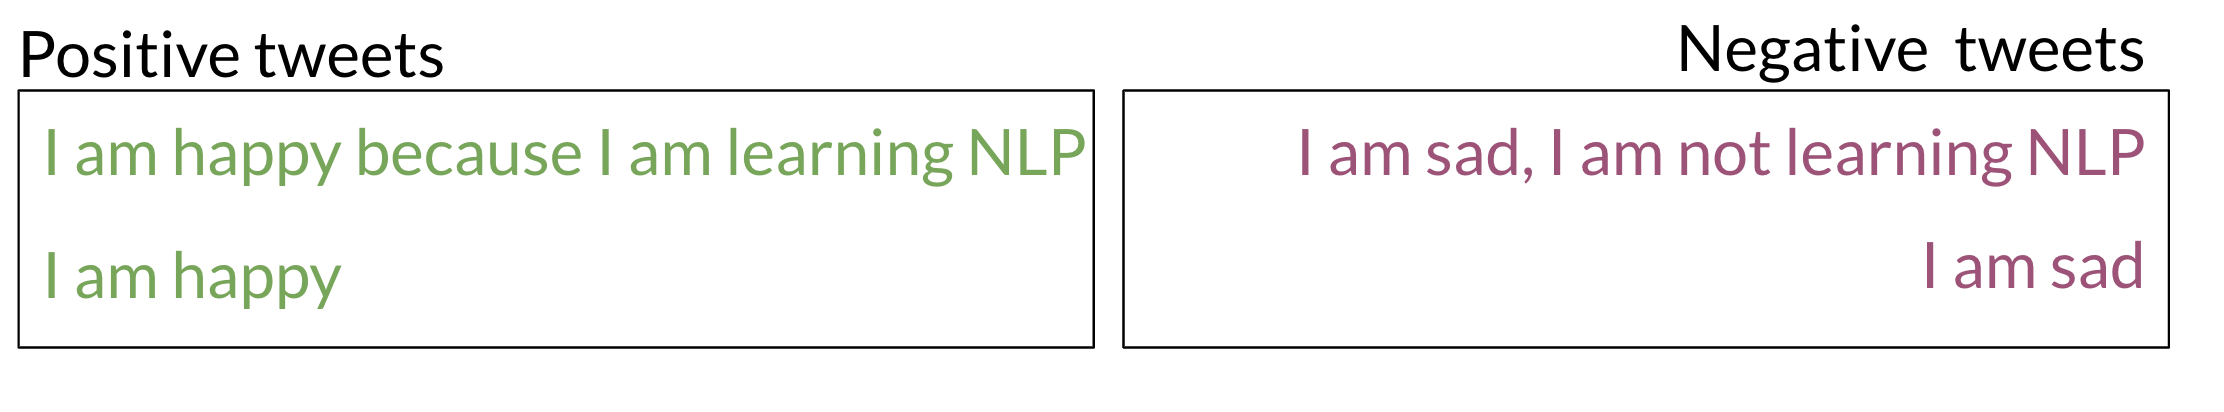

Then the frequency dictionary would look like this:

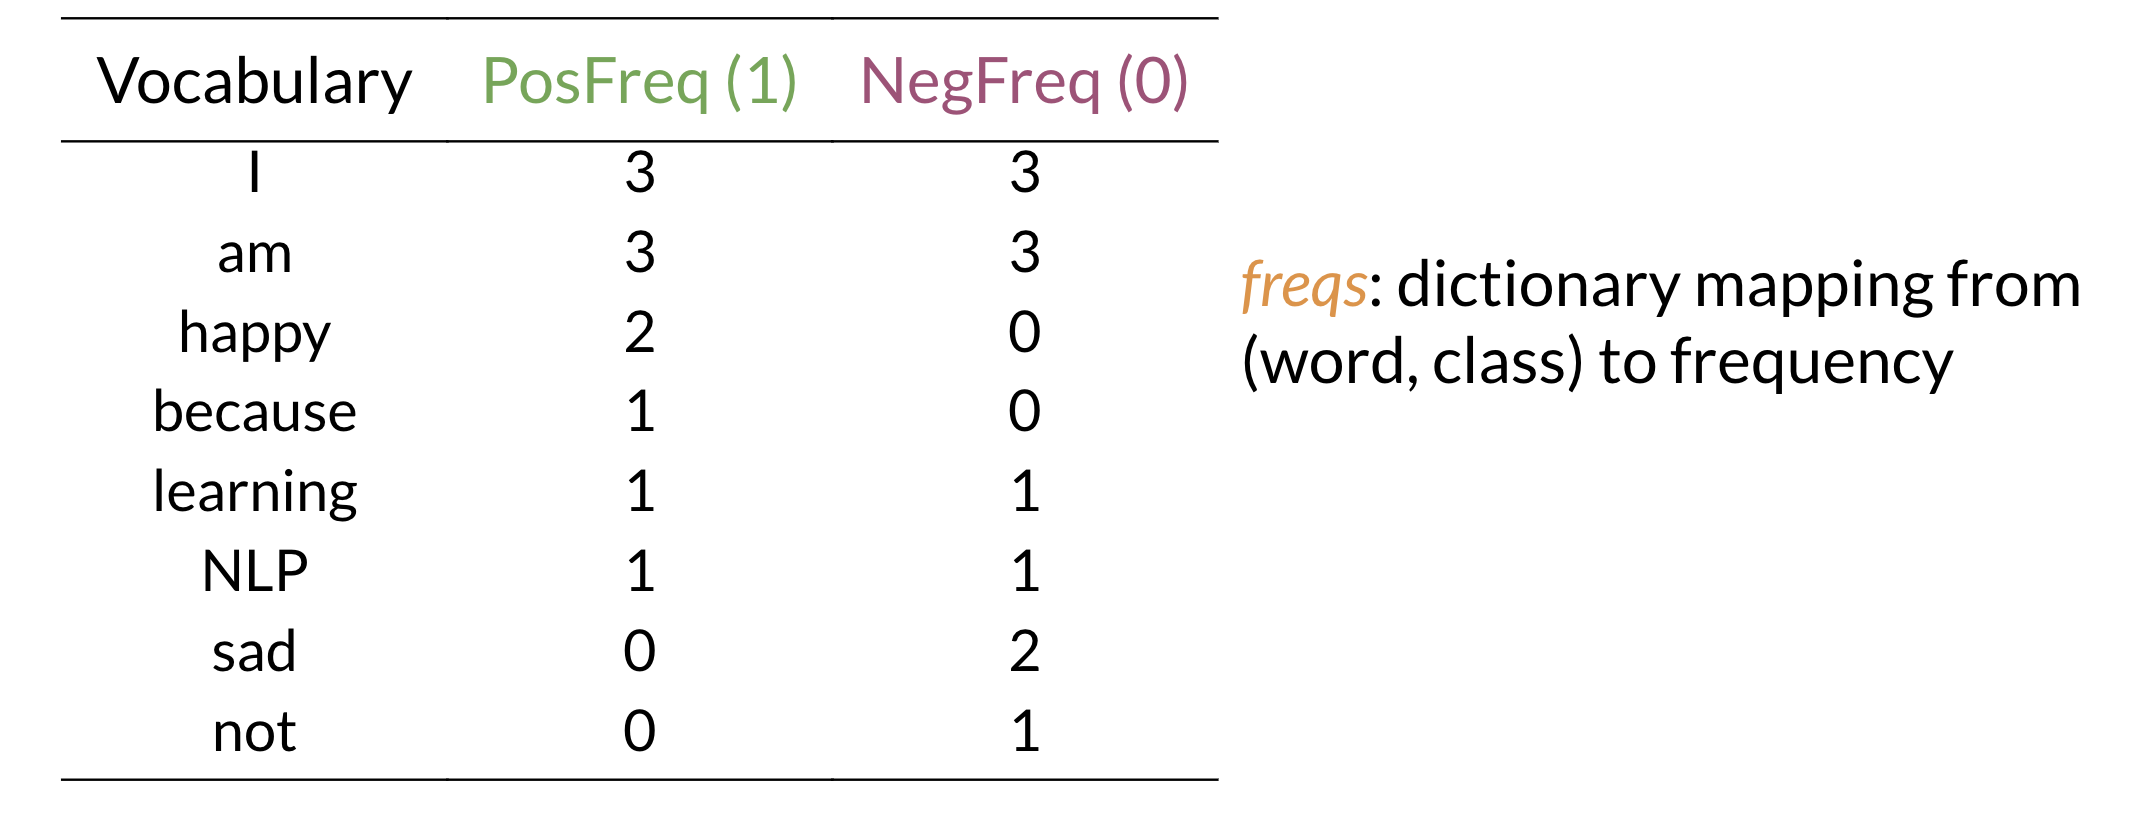

An individual example, then, can be turned into a three-dimensional feature vector via the following formula (the first dimension as the bias feature):

$$X_m = [1, \sum_w freqs(w, 1), \sum_w freqs(w, 0)]$$

Concretely, the example "I am sad, I am not learning NLP" would become the feature vector $[1, 8, 11]$.

It's pretty straightforward to write a function that does this for us:

In [8]:
def get_freqs_dict(labeled_tweets):
    """Build frequencies, adapted from Coursera
    Input:
        labeled_tweets: list of (sentiment: 0 or 1, tweet: string) tuples
    Output:
        freqs: a dictionary mapping each (word, sentiment) pair to its
        frequency
    """

    freqs = {}
    for sentiment, tweet in labeled_tweets:
        for word in process_tweet(tweet):
            pair = (word, sentiment)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

labeled_tweets = [(1, tweet) for tweet in all_positive_tweets] + [(0, tweet) for tweet in all_negative_tweets]
freqs = get_freqs_dict(labeled_tweets)

Using our frequency dictionary, we can then write a function that extracts our desired three dimensional feature vector from a given example:

In [9]:
import numpy as np

def extract_features(tweet, freqs = freqs, process_tweet=process_tweet):
    tweet_processed = process_tweet(tweet)
    x = np.zeros(3)
    x[0] = 1 # bias
    for token in tweet_processed:
        x[1] += freqs.get((token, 1), 0)
        x[2] += freqs.get((token, 0), 0)
    return x

print(tweet)
print(extract_features(tweet))

My beautiful sunflowers on a sunny Friday morning off :) #sunflowers #favourites #happy #Friday off… https://t.co/3tfYom0N1i
[1.000e+00 4.351e+03 1.220e+02]


As you might humanly expect, our tweet has a much higher value for the positive frequency feature than negative.

As a fun exercise, the Coursera lab visualizes the frequencies of a bunch of words on a graph:

In [10]:
keys = ['happi', 'merri', 'nice', 'good', 'bad', 'sad', 'mad', 'best', 'pretti',
        '❤', ':)', ':(', '😒', '😬', '😄', '😍', '♛',
        'song', 'idea', 'power', 'play', 'magnific']

data = [[word, freqs.get((word,1),0), freqs.get((word,0),0)] for word in keys]
print(data)

[['happi', 212, 25], ['merri', 1, 0], ['nice', 99, 19], ['good', 238, 101], ['bad', 18, 73], ['sad', 5, 123], ['mad', 4, 11], ['best', 65, 22], ['pretti', 20, 15], ['❤', 29, 21], [':)', 3691, 2], [':(', 1, 4584], ['😒', 2, 3], ['😬', 0, 2], ['😄', 5, 1], ['😍', 5, 1], ['♛', 0, 210], ['song', 22, 27], ['idea', 27, 10], ['power', 7, 6], ['play', 46, 48], ['magnific', 2, 0]]


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


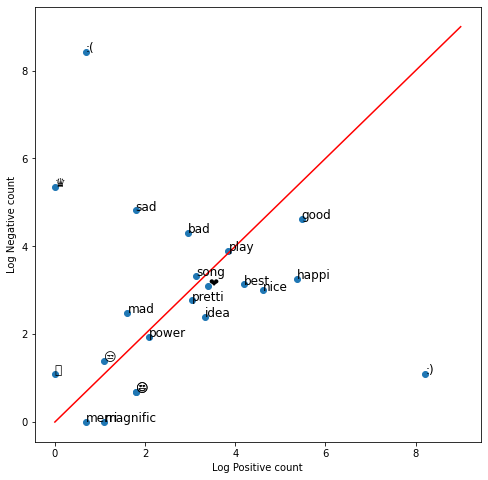

In [11]:
import matplotlib.pyplot as plt

# the following code taken verbatim from lab
fig, ax = plt.subplots(figsize = (8, 8))

# convert positive raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[1] + 1 for x in data])  

# do the same for the negative counts
y = np.log([x[2] + 1 for x in data]) 

# Plot a dot for each pair of words
ax.scatter(x, y)  

# assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

# Add the word as the label at the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([0, 9], [0, 9], color = 'red') # Plot the red line that divides the 2 areas.
plt.show()

Just this data is already pretty interesting. Xuehuai, Satvik and I got an award at DataFest for doing pretty much this kind of frequency analysis (see chart on right):

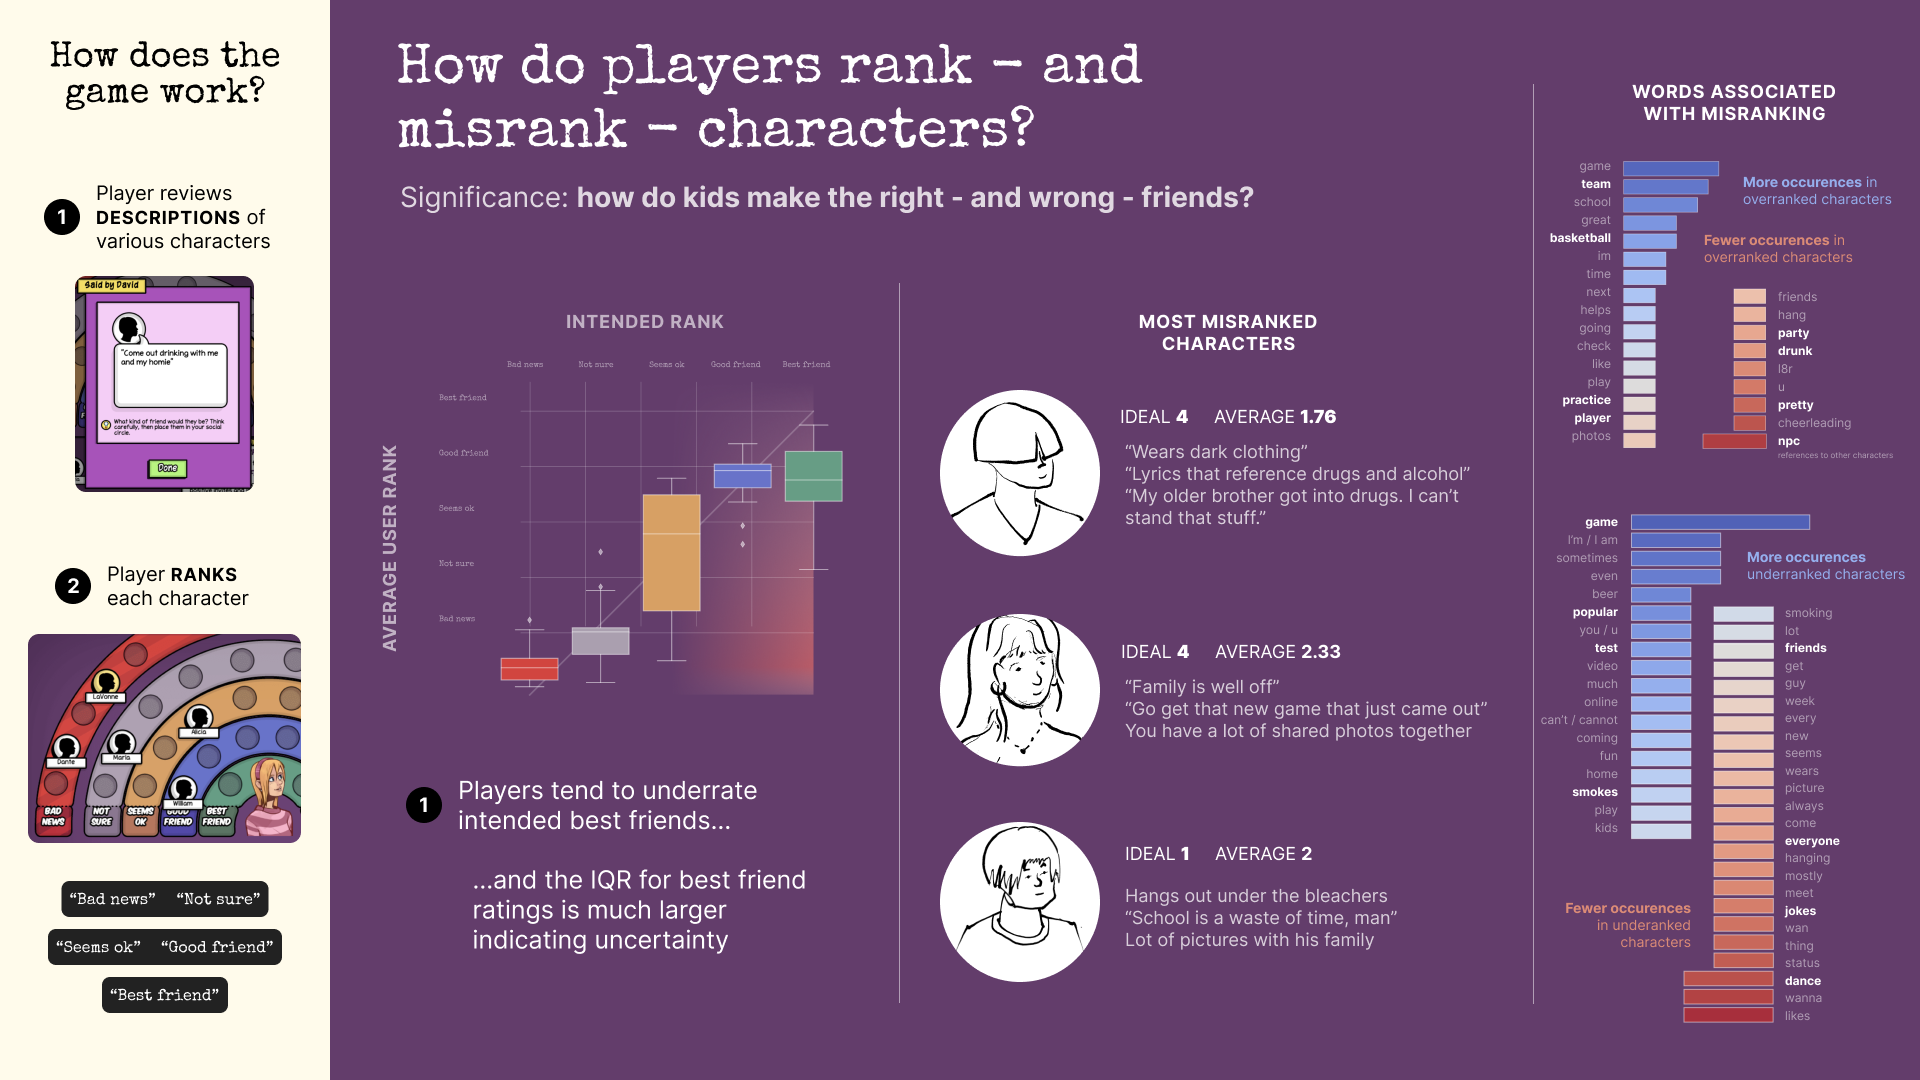

## Logistic regression model

The above is only half of the first week's content. The second half focuses on building a logistic regression model to classify tweets as positive or negative.

Impressively, the Coursera course has learners code an entire logistic regression model from scratch, loss function and gradient descent and all (though with tons of guidance, of course).

I think the mathematical details are really interesting but I've learned it before, so instead I'll Keras to throw the regression model together (referencing [this excellent article](https://www.marktechpost.com/2021/04/08/logistic-regression-with-keras/)):

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(1,activation='sigmoid',input_dim=3))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


2022-05-17 06:00:58.220582: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


To actually train the model, we'll split our data into training and testing data:

In [13]:
test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
train_x = np.array([extract_features(x) for x in train_x])
test_x = test_pos + test_neg
test_x = np.array([extract_features(x) for x in test_x])

print(train_x[0])
print(test_x[0])
print(train_x.shape)
print(test_x.shape)

train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

print(train_y.shape)
print(test_y.shape)

[1.000e+00 3.887e+03 7.200e+01]
[1.000e+00 4.263e+03 5.220e+02]
(8000, 3)
(2000, 3)
(8000, 1)
(2000, 1)


In [14]:
model.fit(train_x,train_y,shuffle=True,epochs=10)

2022-05-17 06:01:02.032175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
250/250 [==============================] - 1s 1ms/step - loss: 7.1172 - binary_accuracy: 0.9550
Epoch 2/10
250/250 [==============================] - 0s 1ms/step - loss: 2.6041 - binary_accuracy: 0.9786
Epoch 3/10
250/250 [==============================] - 0s 1ms/step - loss: 1.6475 - binary_accuracy: 0.9862
Epoch 4/10
250/250 [==============================] - 0s 1ms/step - loss: 1.0956 - binary_accuracy: 0.9901
Epoch 5/10
250/250 [==============================] - 0s 1ms/step - loss: 0.8382 - binary_accuracy: 0.9916
Epoch 6/10
250/250 [==============================] - 0s 1ms/step - loss: 0.7133 - binary_accuracy: 0.9934
Epoch 7/10
250/250 [==============================] - 0s 1ms/step - loss: 0.6363 - binary_accuracy: 0.9945
Epoch 8/10
250/250 [==============================] - 0s 1ms/step - loss: 0.5892 - binary_accuracy: 0.9952
Epoch 9/10
250/250 [==============================] - 0s 1ms/step - loss: 0.5574 - binary_accuracy: 0.9944
Epoch 10/10
250/250 [================

We can test our model on our test data:

In [15]:
model.evaluate(x=test_x,y=test_y)

63/63 [==============================] - 0s 971us/step - loss: 0.0987 - binary_accuracy: 0.9960


[0.09867992252111435, 0.9959999918937683]

Now let's give the model a completely new tweet from my own Twitter and see what it thinks.

In [16]:
my_tweet = "happy to share that @XuehuaiH, Saatvik Kher & I won runner-up for Best Insight among 70+ teams at @UCLADataFest this weekend! thanks to prof @jo_hardin47 for bringing us + for the pics :D"
my_tweet_processed = np.array(extract_features(my_tweet)).reshape((-1,3))
model.predict(my_tweet_processed)

array([[1.]], dtype=float32)

And a negative one:

In [17]:
my_tweet = "\"When Maria Lyven PO ’24 asked her family how they were doing last week, her mother told her that she woke up to the sound of explosions.\" w/ @avjfh and @kata_dot_com , my latest for @TSLnews on the toll of the Ukraine invasion on 5C students:"
my_tweet_processed = np.array(extract_features(my_tweet)).reshape((-1,3))
model.predict(my_tweet_processed)

array([[0.02847812]], dtype=float32)

It does pretty well!

With that I'll close out this notebook, having:
- learned to pre-process sentences (tweets) into clean tokenized lists
- learned to extract frequency features from tokenized lists
- learned to set up a logistic regression model in Keras and train it on the engineered data to give a sentiment score for a given tweet string